In [1]:
#import statements
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [ ]:
## https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [2]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import udf, col, date_format
import pyspark.sql.types as T
from pyspark.ml.feature import CountVectorizer, CountVectorizerModel, IDF, RegexTokenizer, StopWordsRemover
from pyspark.ml.clustering import LDA, LocalLDAModel
from pyspark.ml import Pipeline
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")
import pandas as pd
from wordcloud import WordCloud
import re
import nltk

In [3]:
#create Spark session
spark = SparkSession.builder.appName('Finalproject').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.yarn.jars',
  'local:/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/jars/*,local:/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/hive/*'),
 ('spark.yarn.appMasterEnv.MKL_NUM_THREADS', '1'),
 ('spark.sql.queryExecutionListeners',
  'com.cloudera.spark.lineage.NavigatorQueryListener'),
 ('spark.executor.memory', '5g'),
 ('spark.lineage.log.dir', '/var/log/spark/lineage'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'md01.rcc.local,md02.rcc.local'),
 ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
 ('spark.executorEnv.PYTHONPATH',
  '/opt/cloudera/parcels/CDH/lib/spark/python/lib/py4j-0.10.7-src.zip:/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip<CPS>/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/python/lib/py4j-0.10.7-src.zip<CPS>/opt/cloudera/parcels/CDH-6.3.0-1.cdh6.3.0.p0.1279813/lib/spark/python/lib/pyspark.zip'),

In [3]:
sc = spark.sparkContext

In [4]:
#Reading pdf_json file
df1 = spark.read.json("/user/saduri/data/project_data/pdf_json",multiLine=True);

In [5]:
#collecting all text in JSON object. This collected text from object in list format
#a1=df1.select("body_text.text").collect()
a1=df1.select("body_text.text")
a1.show()

+--------------------+
|                text|
+--------------------+
|[As a rare condit...|
|[This icon indica...|
|[Ce chapitre décr...|
|[Colloquially kno...|
|[At MELD <9, reci...|
|[The aging popula...|
|[Since the beginn...|
|[The following is...|
|[The unexpected S...|
|[Rationale: Expir...|
|[Background. Loca...|
|[Objectives: Sinc...|
|[Introduction Bac...|
|[The liver is a u...|
|[Introduction and...|
|[AHRQ guidelines ...|
|[Diabetes is a ch...|
|[Eukaryotes are c...|
|[The widespread a...|
|[The immune syste...|
+--------------------+
only showing top 20 rows



In [6]:
from pyspark.sql.functions import expr
df2=a1.select(expr("text[0]"))
df2.show()

+--------------------+
|             text[0]|
+--------------------+
|As a rare conditi...|
|This icon indicat...|
|Ce chapitre décri...|
|Colloquially know...|
|At MELD <9, recip...|
|The aging populat...|
|Since the beginni...|
|The following is ...|
|The unexpected SA...|
|Rationale: Expira...|
|Background. Local...|
|Objectives: Since...|
|Introduction Bact...|
|The liver is a un...|
|Introduction and ...|
|AHRQ guidelines f...|
|Diabetes is a chr...|
|Eukaryotes are co...|
|The widespread ap...|
|The immune system...|
+--------------------+
only showing top 20 rows



In [7]:
df3 =df2.limit(7000) # limit the number of rows for LDA to complete running

In [8]:
df3.count()

7000

## First transform dataframe headlines column to RDD to index it to work with

In [9]:
texts=df3.rdd.map(lambda x: x['text[0]'])

In [10]:
#Adding index to data dataframe
headlines=texts.zipWithIndex()

In [11]:
#Creating dataframe
data = sqlContext.createDataFrame(headlines, ["headlines",'index'])

### Normalize and tokenize

In [12]:
removePunct = udf(
    lambda s: re.sub(r'[^a-zA-Z0-9]|[0-9]', r' ', s).strip().lower(), T.StringType())

# normalize the post content (remove html tags, punctuation and lower case..)
data_norm = data.withColumn("text", removePunct(data.headlines))

In [13]:
# tokenize 
tokenizer = RegexTokenizer(inputCol="text", outputCol="words",
                           gaps=True, pattern=r'\s+', minTokenLength=2)
df_tokens = tokenizer.transform(data_norm)

In [14]:
df_tokens.show()

+--------------------+-----+--------------------+--------------------+
|           headlines|index|                text|               words|
+--------------------+-----+--------------------+--------------------+
|There are some me...|    0|there are some me...|[there, are, some...|
|Since the appeara...|    1|since the appeara...|[since, the, appe...|
|Zoonotic emergenc...|    2|zoonotic emergenc...|[zoonotic, emerge...|
|J o u r n a l P r...|    3|j o u r n a l p r...|                  []|
|for its wide use ...|    4|for its wide use ...|[for, its, wide, ...|
|A 20-year-old man...|    5|a    year old man...|[year, old, man, ...|
|1 971 wurden erst...|    6|wurden erstmals  ...|[wurden, erstmals...|
|Emerging and re-e...|    7|emerging and re e...|[emerging, and, r...|
|Kobuvirus (KoV), ...|    8|kobuvirus  kov   ...|[kobuvirus, kov, ...|
|Poultry performan...|    9|poultry performan...|[poultry, perform...|
|health symptoms i...|   10|health symptoms i...|[health, symptoms...|
|ABSTR

## Removing stopwords

In [15]:
nltk.download('stopwords')#must be downloaded to run
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /home/saduri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
removeStop=udf(lambda word: [x for x in word if x not in stopwords])
df_tokens=df_tokens.withColumn('noStopWords',removeStop(df_tokens['words']))

In [17]:
df_tokens.show()

+--------------------+-----+--------------------+--------------------+--------------------+
|           headlines|index|                text|               words|         noStopWords|
+--------------------+-----+--------------------+--------------------+--------------------+
|CoV, MERS-CoV and...|    0|cov  mers cov and...|[cov, mers, cov, ...|[cov, mers, cov, ...|
|The role of the I...|    1|the role of the i...|[the, role, of, t...|[role, institutio...|
|The burden that a...|    2|the burden that a...|[the, burden, tha...|[burden, arises, ...|
|We provide a brie...|    3|we provide a brie...|[we, provide, bri...|[provide, brief, ...|
|A cluster of pneu...|    4|a cluster of pneu...|[cluster, of, pne...|[cluster, pneumon...|
|Wide range of vir...|    5|wide range of vir...|[wide, range, of,...|[wide, range, vir...|
|The ongoing outbr...|    6|the ongoing outbr...|[the, ongoing, ou...|[ongoing, outbrea...|
|The Michigan Medi...|    7|the michigan medi...|[the, michigan, m...|[michigan,

In [18]:
df_tokens.printSchema()

root
 |-- headlines: string (nullable = true)
 |-- index: long (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- noStopWords: string (nullable = true)



#### Changing noStopWords data type

##### It is necessary to change the column data type to run the count vectorizer. It must be T.ArrayType(T.StringType())

In [19]:
label_udf = udf(lambda x: x, T.ArrayType(T.StringType())) 

df_tokens=df_tokens.withColumn('final_words',label_udf(df_tokens.noStopWords))

In [20]:
df_tokens.printSchema()

root
 |-- headlines: string (nullable = true)
 |-- index: long (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- noStopWords: string (nullable = true)
 |-- final_words: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [21]:
df_tokens.show()

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|           headlines|index|                text|               words|         noStopWords|         final_words|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|Sialic acids (Sia...|    0|sialic acids  sia...|[sialic, acids, s...|[sialic, acids, s...|[sialic, acids, s...|
|The estimated pre...|    1|the estimated pre...|[the, estimated, ...|[estimated, preva...|[estimated, preva...|
|recommendation. T...|    2|recommendation  t...|[recommendation, ...|[recommendation, ...|[recommendation, ...|
|In December 2019,...|    3|in december      ...|[in, december, no...|[december, novel,...|[december, novel,...|
|less prevalent, b...|    4|less prevalent  b...|[less, prevalent,...|[less, prevalent,...|[less, prevalent,...|
|proteins. There i...|    5|proteins  there i...|[proteins, there,...|[proteins, differ...|[prot

### TF-IDF Matrix
##### Transforming the rdd into a DataFrame which has two columns — one has index and the other the list of words. CountVectorizer takes this data and returns a sparse matrix of term frequencies attached to the original Dataframe. Same thing goes for the IDF

In [22]:
%%time
# TF
#VocabSize of 20000 words and words with frequencies above 10
cv = CountVectorizer(inputCol="final_words", outputCol="raw_features",vocabSize=20000, minDF=10.0)
cvmodel = cv.fit(df_tokens)

result_cv = cvmodel.transform(df_tokens)

CPU times: user 19.6 ms, sys: 7.54 ms, total: 27.2 ms
Wall time: 6.67 s


In [23]:
%%time
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv)

CPU times: user 12.4 ms, sys: 3.77 ms, total: 16.2 ms
Wall time: 6.03 s


### Train Model

In [24]:
%%time
#split 80% train set and 20% test set
df_training, df_testing = result_tfidf.randomSplit([0.8, 0.2], 1)
print('Training and testing documents: ', df_training.count(), df_testing.count())

num_topics=10
max_iterations=50
lda = LDA(k=num_topics, maxIter=max_iterations)
ldaModel = lda.fit(result_tfidf )

Training and testing documents:  5544 1456
CPU times: user 55.3 ms, sys: 20.1 ms, total: 75.4 ms
Wall time: 3min 2s


In [25]:
topics = ldaModel.describeTopics(maxTermsPerTopic=200)
vocabArray = cvmodel.vocabulary
numTopics=10
ListOfIndexToWords = udf(lambda wl: list([vocabArray[w] for w in wl]))
full_text = topics.select(ListOfIndexToWords(topics.termIndices).alias('words'))#.show(truncate=False, n=numTopics)


In [26]:
full_text = topics.select(ListOfIndexToWords(topics.termIndices).alias('words'))#
full_text.show(truncate=False, n=numTopics)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

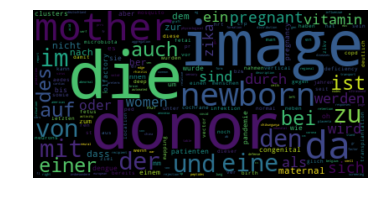

In [27]:
full_text1=full_text.collect()[1]['words']
#print(full_text1)
wordcloud = WordCloud().generate(full_text1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

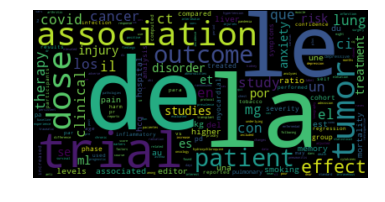

In [28]:
full_text1=full_text.collect()[2]['words']
#print(full_text1)
wordcloud = WordCloud().generate(full_text1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

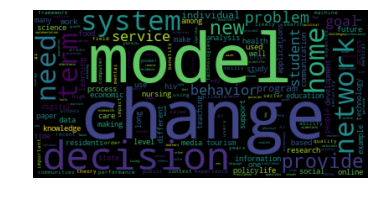

In [29]:
full_text1=full_text.collect()[3]['words']
#print(full_text1)
wordcloud = WordCloud().generate(full_text1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

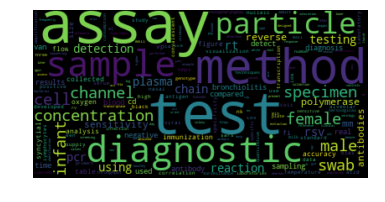

In [30]:
full_text1=full_text.collect()[4]['words']
#print(full_text1)
wordcloud = WordCloud().generate(full_text1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

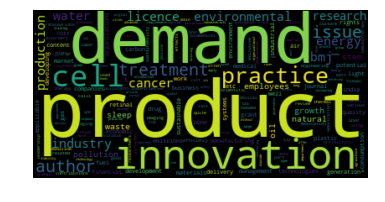

In [31]:
full_text1=full_text.collect()[5]['words']
#print(full_text1)
wordcloud = WordCloud().generate(full_text1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

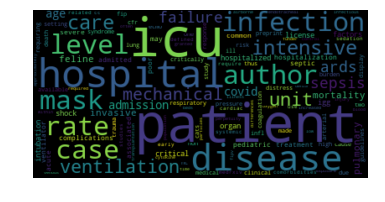

In [32]:
full_text1=full_text.collect()[6]['words']
#print(full_text1)
wordcloud = WordCloud().generate(full_text1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

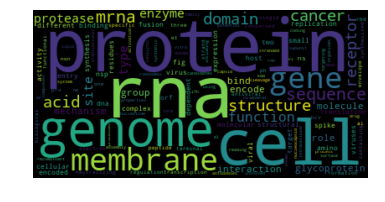

In [33]:
full_text1=full_text.collect()[7]['words']
#print(full_text1)
wordcloud = WordCloud().generate(full_text1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

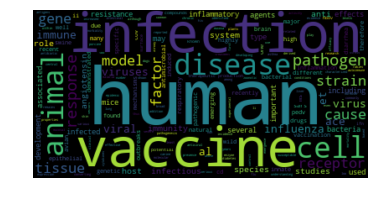

In [34]:
full_text1=full_text.collect()[8]['words']
#print(full_text1)
wordcloud = WordCloud().generate(full_text1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [35]:
full_text9=full_text.collect()[9]['words']
print(full_text9)

[covid, health, pandemic, cases, spread, world, countries, care, risk, transmission, disease, patients, public, measures, healthcare, people, coronavirus, march, china, outbreak, sars, number, global, deaths, emergency, medical, epidemic, confirmed, hospital, workers, cov, social, states, first, worldwide, population, organization, contact, reported, new, patient, infection, united, distancing, virus, million, may, control, many, days, severe, infected, individuals, lockdown, affected, case, respiratory, wuhan, declared, international, time, data, since, travel, across, early, impact, italy, novel, country, th, april, caused, including, rapidly, mental, mortality, acute, community, person, national, december, surgical, prevention, quarantine, outbreaks, due, around, among, systems, period, high, infectious, january, crisis, testing, also, hospitals, syndrome, government, ppe, isolation, implemented, however, effective, rate, management, need, general, us, rapid, staff, study, current, 

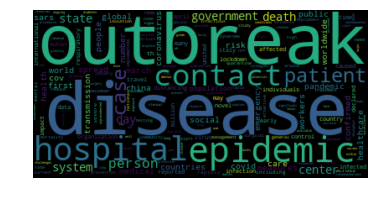

In [36]:
wordcloud = WordCloud().generate(full_text9)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

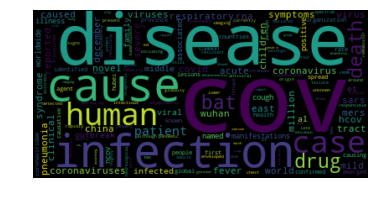

In [37]:
full_text1=full_text.first()['words']
wordcloud = WordCloud().generate(full_text1)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
#This is first topic

In [38]:
# Print topics and top-weighted terms
topics = ldaModel.describeTopics(maxTermsPerTopic=12)
vocabArray = cvmodel.vocabulary
numTopics=10

ListOfIndexToWords = udf(lambda wl: list([vocabArray[w] for w in wl]))
FormatNumbers = udf(lambda nl: ["{:1.4f}".format(x) for x in nl])

topics.select(ListOfIndexToWords(topics.termIndices).alias('words')).show(truncate=False, n=numTopics)
topics.select(FormatNumbers(topics.termWeights).alias('weights')).show(truncate=False, n=numTopics)

+-----------------------------------------------------------------------------------------------------------------+
|words                                                                                                            |
+-----------------------------------------------------------------------------------------------------------------+
|[cov, sars, respiratory, coronavirus, syndrome, severe, acute, pneumonia, virus, disease, mers, symptoms]        |
|[der, die, und, von, zu, mit, das, den, eine, im, einer, auf]                                                    |
|[de, la, patients, en, el, il, cancer, con, ci, les, que, lung]                                                  |
|[social, learning, information, research, students, health, education, data, services, models, model, work]      |
|[pcr, rt, test, chain, rsv, detection, reaction, using, samples, testing, tests, assays]                         |
|[cancer, production, energy, industry, environmental, products, bmj, wa

### Top Topics

In [39]:
toptopics = topics.select((topics.topic + 1).alias('topic'),
                          ListOfIndexToWords(topics.termIndices).alias('words'),
                          FormatNumbers(topics.termWeights).alias('weights'))
toptopics.show(truncate=False, n=numTopics)
print('Topics:', numTopics, 'Vocabulary:', len(vocabArray))

+-----+-----------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------+
|topic|words                                                                                                            |weights                                                                                         |
+-----+-----------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------+
|1    |[cov, sars, respiratory, coronavirus, syndrome, severe, acute, pneumonia, virus, disease, mers, symptoms]        |[0.0129, 0.0116, 0.0108, 0.0096, 0.0079, 0.0070, 0.0066, 0.0064, 0.0061, 0.0058, 0.0052, 0.0051]|
|2    |[der, die, und, von, zu, mit, das, den, eine, im, einer, auf]                                                    |[0.

In [40]:
toptopics = topics.select(topics.topic .alias('topic'),
                          ListOfIndexToWords(topics.termIndices).alias('words')
                          )
toptopics.show(truncate=False, n=numTopics)
print('Topics:', numTopics, 'Vocabulary:', len(vocabArray))

+-----+-----------------------------------------------------------------------------------------------------------------+
|topic|words                                                                                                            |
+-----+-----------------------------------------------------------------------------------------------------------------+
|0    |[cov, sars, respiratory, coronavirus, syndrome, severe, acute, pneumonia, virus, disease, mers, symptoms]        |
|1    |[der, die, und, von, zu, mit, das, den, eine, im, einer, auf]                                                    |
|2    |[de, la, patients, en, el, il, cancer, con, ci, les, que, lung]                                                  |
|3    |[social, learning, information, research, students, health, education, data, services, models, model, work]      |
|4    |[pcr, rt, test, chain, rsv, detection, reaction, using, samples, testing, tests, assays]                         |
|5    |[cancer, producti

In [54]:
#wordc1 = topics.select(ListOfIndexToWords(topics.termIndices).alias('words'))
#wordc1.show(truncate=False)


In [55]:
#text=wordc1.select(expr("words[0]"))
#text=wordc1.first()['words']
#print(text)

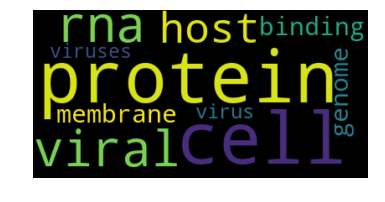

In [82]:
#from pyspark.sql.functions import getItem
# Create and generate a word cloud image:
#for row in wordc1:
#text=wordc1(expr("words[0]"))
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
### Save model
print(ldaModel.isDistributed())
path = "gs://bucket_name/LDAModel/"

model_number = 'x'
cvModel.save(path + 'CVModel'+ model_number)
ldaModel.save(path + 'LDAModel'+ model_number)
lda.save(path + 'LDA_'+ model_number)

In [ ]:
## Details of some topics.In this case 5 topics. It can be displayed all the topics

In [41]:
df = ldaModel.transform(result_tfidf) #defining the dataframe
numTopics_toShow=10 #
topWords = topics.select(ListOfIndexToWords(topics.termIndices).alias('words')).take(numTopics_toShow)

nTopDoc = 3  # show single top document (1) or also second (2) ..

for i in range(0, numTopics_toShow):
    ntopic = i  # which topic 
    print('Topic ' + str(ntopic) + '\n')  

    df_sliced = df.select("index", "topicDistribution") \
        .rdd.map(lambda r: Row(ID=int(r[0]), weight=float(r[1][ntopic]))).toDF()

    DocIDs = df_sliced.sort(df_sliced.weight.desc()).take(nTopDoc)
    print('Top Document(s):',DocIDs)
    for d_id in DocIDs:
        df_tokens.filter(df_tokens.index == d_id[0]) \
            .select('headlines') \
            .show(truncate=False)

    print('Top terms:')
    print(topWords[ntopic][0], '\n')
    print('===================================================')

Topic 0

Top Document(s): [Row(ID=5809, weight=0.9983331082225574), Row(ID=1465, weight=0.9979794603225425), Row(ID=5044, weight=0.9978493285745234)]
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|headlines                                                                                                                                                                                                                                                                                                                                                                       |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|headlines                                                                                                                                                                                                                                                                                                                                                                                                                                               

Top Document(s): [Row(ID=5375, weight=0.9993726462118829), Row(ID=2117, weight=0.9990719712056553), Row(ID=3220, weight=0.9984252368740016)]
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|headlines                                                                                                                                                                                                                                                                                                                           |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Top Document(s): [Row(ID=2976, weight=0.9969519950404158), Row(ID=4438, weight=0.9952194645647756), Row(ID=4144, weight=0.9945128748402606)]
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Top Document(s): [Row(ID=290, weight=0.9977745108011479), Row(ID=327, weight=0.9977745108011479), Row(ID=212, weight=0.9977745108011479)]
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|headlines                                                                                                                                                                                                                                                                                                                   

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|headlines                                                                                                                                                                                                                                                                                              |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Introduction: Three cases are presented that are characterised by an acute psychopathological decompensat

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|headlines                                                                                                                                                                                                                                                                                                 

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|headlines                                                                                                                                                                                                                                                                                                                                                                           |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Top Document(s): [Row(ID=391, weight=0.9984867793517949), Row(ID=1533, weight=0.9980002053670618), Row(ID=5864, weight=0.9979970908907867)]
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|headlines                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
+-------

In [ ]:
## Details of a single topic

In [ ]:
### It includes the top topic or second, third, etc., in this case second form example, and the x top terms, in this case 5

In [57]:
# find the top documents according to lda for topic number ntopic
ntopic = 3 # number of topic
nTopDoc = 2 # show top document (1) or second (2) ...

df_sliced = df.select("index","topicDistribution").rdd.map(lambda r: Row(ID = int(r[0]),
                                                                         sliced = float(r[1][ntopic]))).toDF()
topDocID = df_sliced.sort(df_sliced.sliced.desc()).take(nTopDoc)[nTopDoc-1][0]
print(topDocID)
print('Topic ' + str(ntopic) +'\n')

print('Second Document:',DocIDs)
df_tokens.filter(df_tokens.index == topDocID)\
    .select('headlines')\
    .show(truncate = False)

print('Top 5 terms:')
print(topics.select(ListOfIndexToWords(topics.termIndices).alias('words')).take(numTopics)[ntopic][0], '\n')

1090
Topic 3

Second Document: [Row(ID=542, weight=0.7985314846304268)]
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|headlines                                                                                                                                                                                                                                                                                                                      |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [29]:
### Plot the top documents result

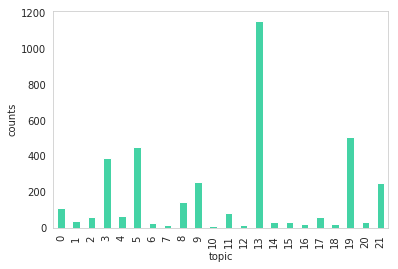

In [39]:
countTopDocs = df.select('topicDistribution')\
                .rdd.map(lambda r: Row( nTopTopic = int(np.argmax(r)))).toDF() \
                .groupBy("nTopTopic").count().sort("nTopTopic")

pdf = countTopDocs.toPandas()
pdfLess = pdf.drop(pdf.index[[1,3,7,8,10,11,14,15]]).reset_index()

pdfLess.plot(color = '#44D3A5', legend = False,
                           kind = 'bar', use_index = True, y = 'count', grid = False)
plt.xlabel('topic')
plt.ylabel('counts')

plt.show()

In [65]:
pdf.head(10)

,nTopTopic,count
0,0,378
1,1,60
2,2,79
3,3,76
4,4,24
5,5,14
6,6,463
7,7,15
8,8,170
9,9,161


In [66]:
pdf=pdf.iloc[0:9,0:9]
pdf.head(5)

,nTopTopic,count
0,0,378
1,1,60
2,2,79
3,3,76
4,4,24


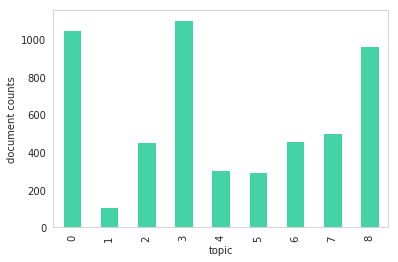

In [42]:
countTopDocs = df.select('topicDistribution')\
                .rdd.map(lambda r: Row( nTopTopic = int(np.argmax(r)))).toDF() \
                .groupBy("nTopTopic").count().sort("nTopTopic")

pdf = countTopDocs.toPandas()
pdf=pdf.iloc[0:9,0:9]
#pdfLess = pdf.drop(pdf.index[[1,3,7,8,10,11,14,15]]).reset_index()

pdf.plot(color = '#44D3A5', legend = False,
                           kind = 'bar', use_index = True, y = 'count', grid = False)
plt.xlabel('topic')
plt.ylabel('document counts')

plt.show()